# Sparkgeo GoGeomatics Workshop

### ARD (Analysis Ready Data)
Now that we have seen our data and created some basic metadata from it. It is now ready to be analyzed. The data is Analysis Ready.

Let's exploit it and do some basic zonal statistics.
We are going to do the following:
 - Create a polygon from a buffered lat/long point
 - Build a PDAL pipeline to filter the data and spatially subset the data
 - View the data subset

In [1]:
#!pip install shapely
#!pip install pyproj
#!pip install pillow

import pyproj
from PIL import Image
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info

def get_utm(point):
    # Estimate the first UTM from the latlong
    longitude, latitude = point.x, point.y
    buffer = 0.001
    utm_crs_list = query_utm_crs_info(
        datum_name="WGS 84",
        area_of_interest=AreaOfInterest(
            west_lon_degree=longitude - buffer,
            south_lat_degree=latitude - buffer,
            east_lon_degree=longitude + buffer,
            north_lat_degree=latitude + buffer,
        ),
    )
    utm_crs = pyproj.CRS.from_epsg(utm_crs_list[0].code)
    return utm_crs

In [2]:
zonal_stats_point = {"type": "Point", "coordinates": [-111.3846, 56.7936]}
from shapely.geometry import shape
from shapely.ops import transform

geom = shape(zonal_stats_point)
utm = get_utm(geom)
wgs84 = pyproj.CRS("EPSG:4326")

project_dd_to_utm = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True).transform
project_utm_to_dd = pyproj.Transformer.from_crs(utm, wgs84, always_xy=True).transform

utm_point = transform(project_dd_to_utm, geom)
window = utm_point.buffer(100)

window_dd = transform(project_utm_to_dd, window)

In [3]:
import json
import pdal 

# Define the PDAL pipeline to read from the NRCan COPC repository (stored on AWS s3)
# Fort McMurray COPC File.

# This method of using PDAL is different than the one presented earlier. However, they perform the same task.
polygon = window.wkt + f" / EPSG:{utm.to_epsg()}"

reader = pdal.Reader.copc(
        "https://ftp-maps-canada-ca.s3.amazonaws.com/pub/elevation/pointclouds_nuagespoints/NRCAN/Fort_McMurray_2018/AB_FortMcMurray2018_20180518_NAD83CSRS_UTMZ12_1km_E4760_N62940_CQL1_CLASS.copc.laz",
        requests=3,
        resolution=2.0,
        polygon=polygon
    )

In [4]:
assign = pdal.Filter.assign(value=["Intensity = Intensity / 256"])


In [5]:
writer = pdal.Writer.gdal(
    "intensity.tif",
    resolution=2.0,
    dimension="Intensity",
    data_type="uint8",
    output_type="mean",
)

In [6]:
pipeline = reader
pipeline = pipeline | assign | writer

In [8]:
%%time

# Use streaming mode at 1e6 points at a time. This
# helps us conserve memory for pipelines that are streamable
# check that with the pipeline.streamable property
results = pipeline.execute_streaming(chunk_size=1000000)
print(pipeline.log)

# the last stage of our pipeline is the writer, and the 'dimension'
# option on the writer is what we want to print
dimension = pipeline.stages[-1].options["dimension"]
print(f"Number of points returned for dimension {dimension}: {results}")


Number of points returned for dimension Intensity: 56310
CPU times: user 3.61 s, sys: 219 ms, total: 3.83 s
Wall time: 6.88 s


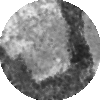

In [9]:
Image.open("intensity.tif")

Lets compute the height above ground using a nearest neighbour filter.
This filter selects `ASPRS Standard` Classification 2 as the ground points in the data.

See the [documents.](
https://pdal.io/en/2.6.0/stages/filters.hag_nn.html)


In [11]:
import numpy

hag = pdal.Filter.hag_nn()
writer = pdal.Writer.gdal(
    "hag.tif",
    resolution=2.0,
    dimension="HeightAboveGround",
    data_type="float32",
    output_type="mean",
)

pipeline = None
pipeline = reader
pipeline = pipeline | hag | writer
p = pipeline.execute()

# Access the Numpy Array
arr = pipeline.arrays[0]

print(f"The maximum height in m in the subseted dataset is {numpy.max(arr["HeightAboveGround"])}m")

The maximum height in m in the subseted dataset is 28.25m
